In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn import preprocessing as prep

# 5000Songs Example

## Import songs_df

In [2]:
songs_df = pd.read_csv("..\datasets\df_audio_features_5000.csv")
songs_df.columns = songs_df.columns.str.strip()

In [3]:
songs_df

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.6580,0.25900,11,-13.141,0,0.0705,0.694,0.000059,0.9750,0.3060,110.376,,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.7420,0.39900,2,-12.646,1,0.0346,0.217,0.000002,0.1070,0.6930,125.039,,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.8510,0.73000,2,-11.048,1,0.3470,0.453,0.000063,0.1240,0.9050,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...
3,Mulher Eu Sei ...,Chico César,0.7050,0.05020,4,-18.115,1,0.0471,0.879,0.000041,0.3860,0.5240,106.802,,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...
4,Rosa Morena ...,Kurt Elling,0.6510,0.11900,6,-19.807,1,0.0380,0.916,0.000343,0.1040,0.4020,120.941,,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5230,"1812 Festival Overture, Op. 49: 1812 Overture,...",Pyotr Ilyich Tchaikovsky,0.2020,0.06940,3,-23.390,1,0.0473,0.917,0.715000,0.0832,0.0655,87.906,,995000,4,1aEhYlZtypmipA06SDJ4U3,https://open.spotify.com/track/1aEhYlZtypmipA0...
5231,"Winter Fragments pour ensemble instrumental, s...",Tristan Murail,0.1880,0.10100,6,-21.873,1,0.0442,0.855,0.426000,0.0694,0.0355,83.134,,855000,4,1Gfqe7TAKklmuZf6hxsH6h,https://open.spotify.com/track/1Gfqe7TAKklmuZf...
5232,"Schoenberg: 5 Orchestral Pieces, Op. 16: No. 3...",Arnold Schoenberg,0.0596,0.00093,9,-42.959,1,0.0434,0.951,0.969000,0.0772,0.0344,71.573,,238187,3,2XNwnFrdMDpismp0VUZ7cU,https://open.spotify.com/track/2XNwnFrdMDpismp...
5233,"Serenade For Strings In E, Op.22, B. 52: 1. Mo...",Antonín Dvořák,0.1330,0.02080,4,-29.443,1,0.0419,0.883,0.505000,0.1110,0.0591,67.109,,314307,4,7ucDwgMtE3YJtEfTbuRhy0,https://open.spotify.com/track/7ucDwgMtE3YJtEf...


### Decide for some features
Keep the following

- **energy**
is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.	Float

- **loudness**
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typically range between -60 and 0 db.	Float

- **acousticness**
A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.	Float


- **tempo**
The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.	Float


In [4]:
feat_l = ["energy","acousticness","tempo","loudness"]

### Remove outliers

In [5]:
def analyze_outliers(df,col,action="keep"):
    Q1   = col.quantile(0.25)
    Q3   = col.quantile(0.75)
    IQR = Q3 - Q1
    num_inliers =((col >= (Q1 - 1.5*IQR)) & (col <= (Q3 + 1.5*IQR))).sum()
    num_outliers = df.shape[0]-num_inliers
    per_outliers = round((num_outliers/df.shape[0])*100,2)
    print(f'''{num_outliers} out of {df.shape[0]} are outliers, ie {per_outliers}%''')
    if action == "delete":
        df=df.loc[((col >= (Q1 - 1.5*IQR)) & (col <= (Q3 + 1.5*IQR)))]
    return df

In [6]:
songs_c_df=pd.DataFrame({})
for feat in feat_l:
    songs_df = analyze_outliers(songs_df,songs_df[feat],action="delete")
    songs_c_df[feat] = songs_df[feat]

0 out of 5235 are outliers, ie 0.0%
0 out of 5235 are outliers, ie 0.0%
51 out of 5235 are outliers, ie 0.97%
352 out of 5184 are outliers, ie 6.79%


In [7]:
songs_c_df

,energy,acousticness,tempo,loudness
0,0.25900,0.694,110.376,-13.141
1,0.39900,0.217,125.039,-12.646
2,0.73000,0.453,93.698,-11.048
3,0.05020,0.879,106.802,-18.115
4,0.11900,0.916,120.941,-19.807
...,...,...,...,...
5230,0.06940,0.917,87.906,NaN
5231,0.10100,0.855,83.134,NaN
5232,0.00093,0.951,71.573,NaN
5233,0.02080,0.883,67.109,NaN


In [8]:
songs_c_df = songs_c_df.dropna()

In [9]:
songs_c_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4832 entries, 0 to 5227
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   energy        4832 non-null   float64
 1   acousticness  4832 non-null   float64
 2   tempo         4832 non-null   float64
 3   loudness      4832 non-null   float64
dtypes: float64(4)
memory usage: 188.8 KB


## Static functions defintion

In [10]:
# a Bussines need ,keep the size of all the playlists at between 50 and 250 songs.
MIN_SAMPLE_P_CLUSTER = 50
MAX_SAMPLE_P_CLUSTER = 250

In [11]:
def get_kval_range(df):
    num_samples = df.shape[0]
    min_k = round(num_samples/MAX_SAMPLE_P_CLUSTER)
    max_k = round(num_samples/MIN_SAMPLE_P_CLUSTER)
    return(min_k,max_k)

In [12]:
from sklearn import preprocessing,cluster
from sklearn.metrics import silhouette_score,silhouette_samples,pairwise_distances
import numpy as np

def run_std_Kmean(df,k_value):
    # Perform Data Scalling
    my_scaler = preprocessing.StandardScaler().set_output(transform='pandas')
    scaled_df = my_scaler.fit_transform(df)
    
    # Operate KMean Method
    my_model = cluster.KMeans(n_clusters=k_value,n_init=10, random_state=123)
    my_model.fit(scaled_df)
    
    # save some of Model variables for further usage
    labels = my_model.labels_
    centroids  = my_model.cluster_centers_ 
    inertia = my_model.inertia_

    # Calculate the silhouette score
    silhouette_avg = silhouette_score(scaled_df, labels)
    sample_sil_val = silhouette_samples(scaled_df, labels)
    
    #TODO: find n nearest points to centroid
    # # Calculate nearest 50 samples to the centzroid
    # ith_nearst = 20
    # distances = pairwise_distances(centroids, scaled_df, metric='euclidean')
    # ind = [np.argpartition(i, ith_nearst)[:ith_nearst] for i in distances]
    # closest = [scaled_df[indexes] for indexes in ind]


    print(f"* For k = {k_value} the average to silhouette is: {round(silhouette_avg,4)}")
    # Draw the Sil value Per cluster for k = k_value
    fig,axis = plt.subplots(1, 1)
    fig.set_size_inches(20, 10)
    
    axis.axvline(x=silhouette_avg, color="red", linestyle="--")
    y_lower = 10
    for i in range(k_value): 
        ith_cluster_sv = sample_sil_val[labels == i]
        #print(f"\t- For cluster = {i} the silhouette value is: {round(np.mean(ith_cluster_sv),2)}")
        
        ith_cluster_sv.sort()
        # Calculate where to put the silhuette on the y axes
        ith_cluster_size = ith_cluster_sv.shape[0]
        y_upper = y_lower + ith_cluster_size

        
        # Paint the cluster
        axis.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sv, alpha = 0.7)
        # Label the cluster
        axis.text(-0.05, y_lower + 0.5 * ith_cluster_size, str(i))
        
        # Calculate the next y lower value for the next cluster of the graph
        y_lower = y_upper + 10 # we left 10 spaces without any observation
        
    axis.set_title("Silhouette score for k = %s"%str(k_value))
    axis.set_xlabel("S(i)")
    axis.set_ylabel("Cluster ID")
    
    return (inertia,silhouette_avg,labels)

In [13]:
def draw_3styled_vlines(xvals,ymin,ymax):
    plt.vlines(x=xvals[0],ymin=ymin,ymax=ymax,colors="green", linestyles='dashed',label='Kvalue_1',alpha = 0.5)
    plt.vlines(x=xvals[1],ymin=ymin,ymax=ymax,colors="grey", linestyles='dashed',label='Kvalue_2',alpha = 0.5)
    plt.vlines(x=xvals[2],ymin=ymin,ymax=ymax,colors="blue", linestyles='dashed',label='Kvalue_3',alpha = 0.5)
    plt.legend()

## Choose K Value Range

In [14]:
(k_min,k_max) = get_kval_range(songs_c_df) 
(k_min,k_max)


(19, 97)

In [15]:
#TODO: to speed up calculations
k_max=35
(k_min,k_max)

(19, 35)

### Use StanderdScaler

* For k = 19 the average to silhouette is: 0.2482
* For k = 20 the average to silhouette is: 0.2472
* For k = 21 the average to silhouette is: 0.239
* For k = 22 the average to silhouette is: 0.2371
* For k = 23 the average to silhouette is: 0.2412
* For k = 24 the average to silhouette is: 0.23
* For k = 25 the average to silhouette is: 0.2331
* For k = 26 the average to silhouette is: 0.2407
* For k = 27 the average to silhouette is: 0.2353
* For k = 28 the average to silhouette is: 0.2324
* For k = 29 the average to silhouette is: 0.2304
* For k = 30 the average to silhouette is: 0.2359
* For k = 31 the average to silhouette is: 0.2381
* For k = 32 the average to silhouette is: 0.2312
* For k = 33 the average to silhouette is: 0.226
* For k = 34 the average to silhouette is: 0.2376


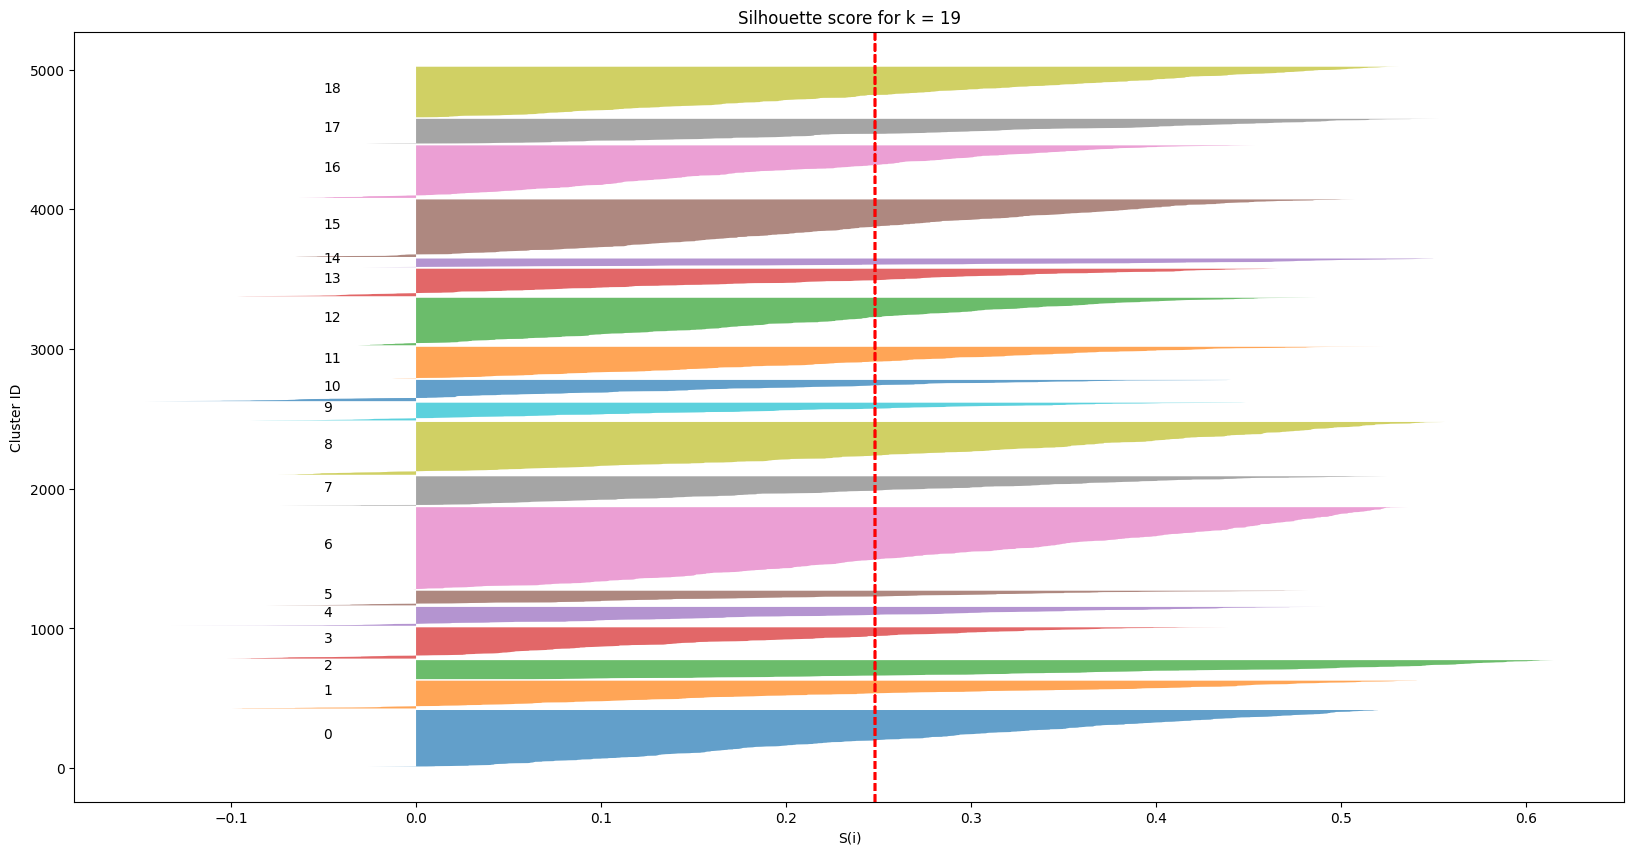

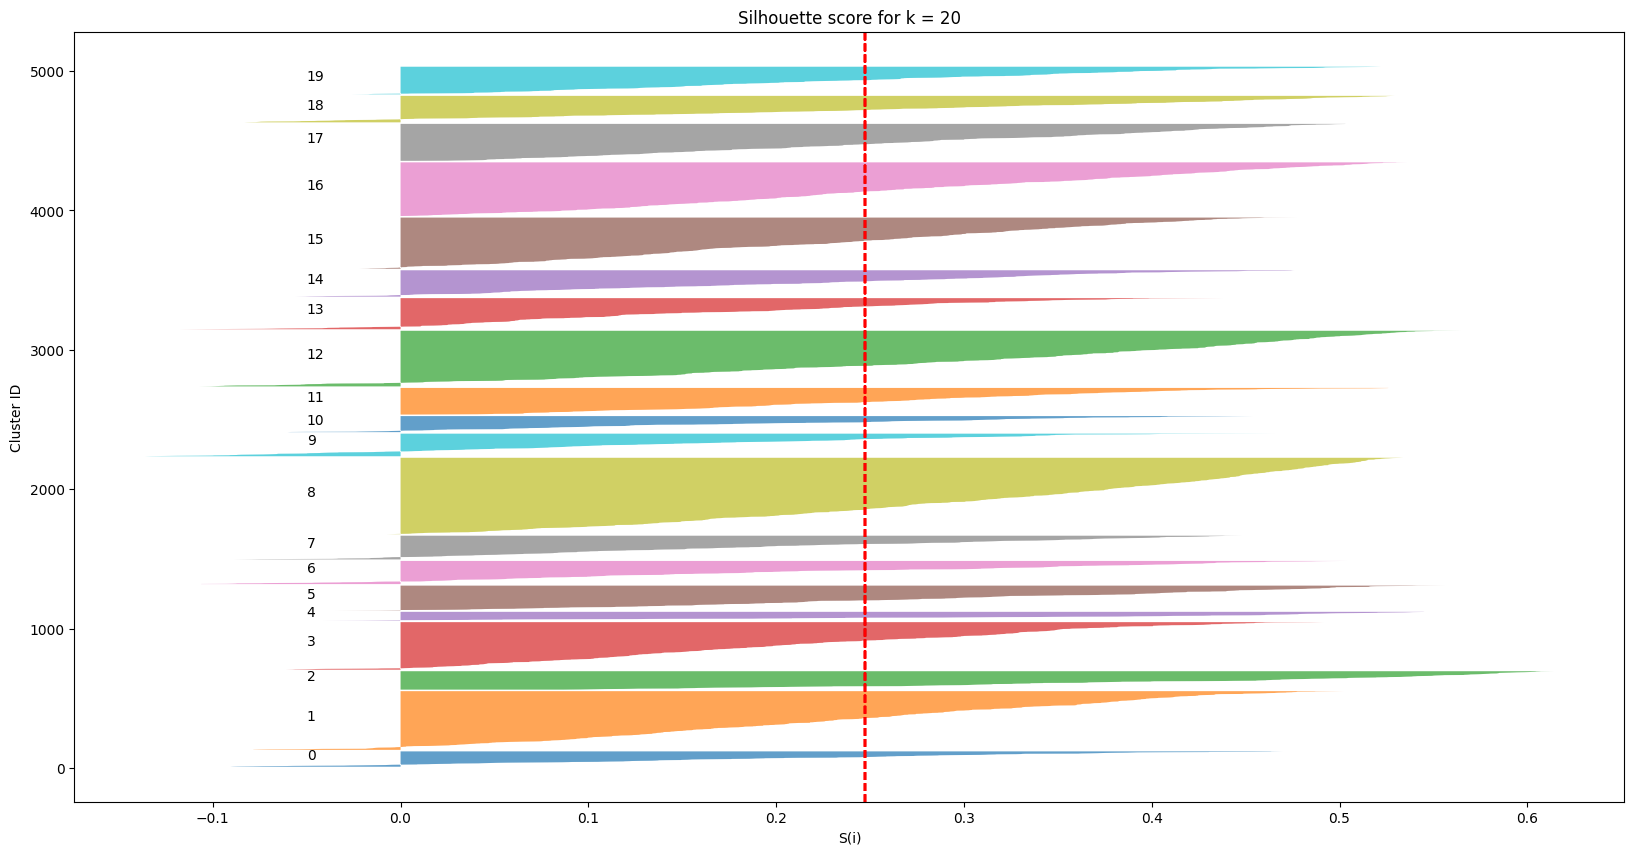

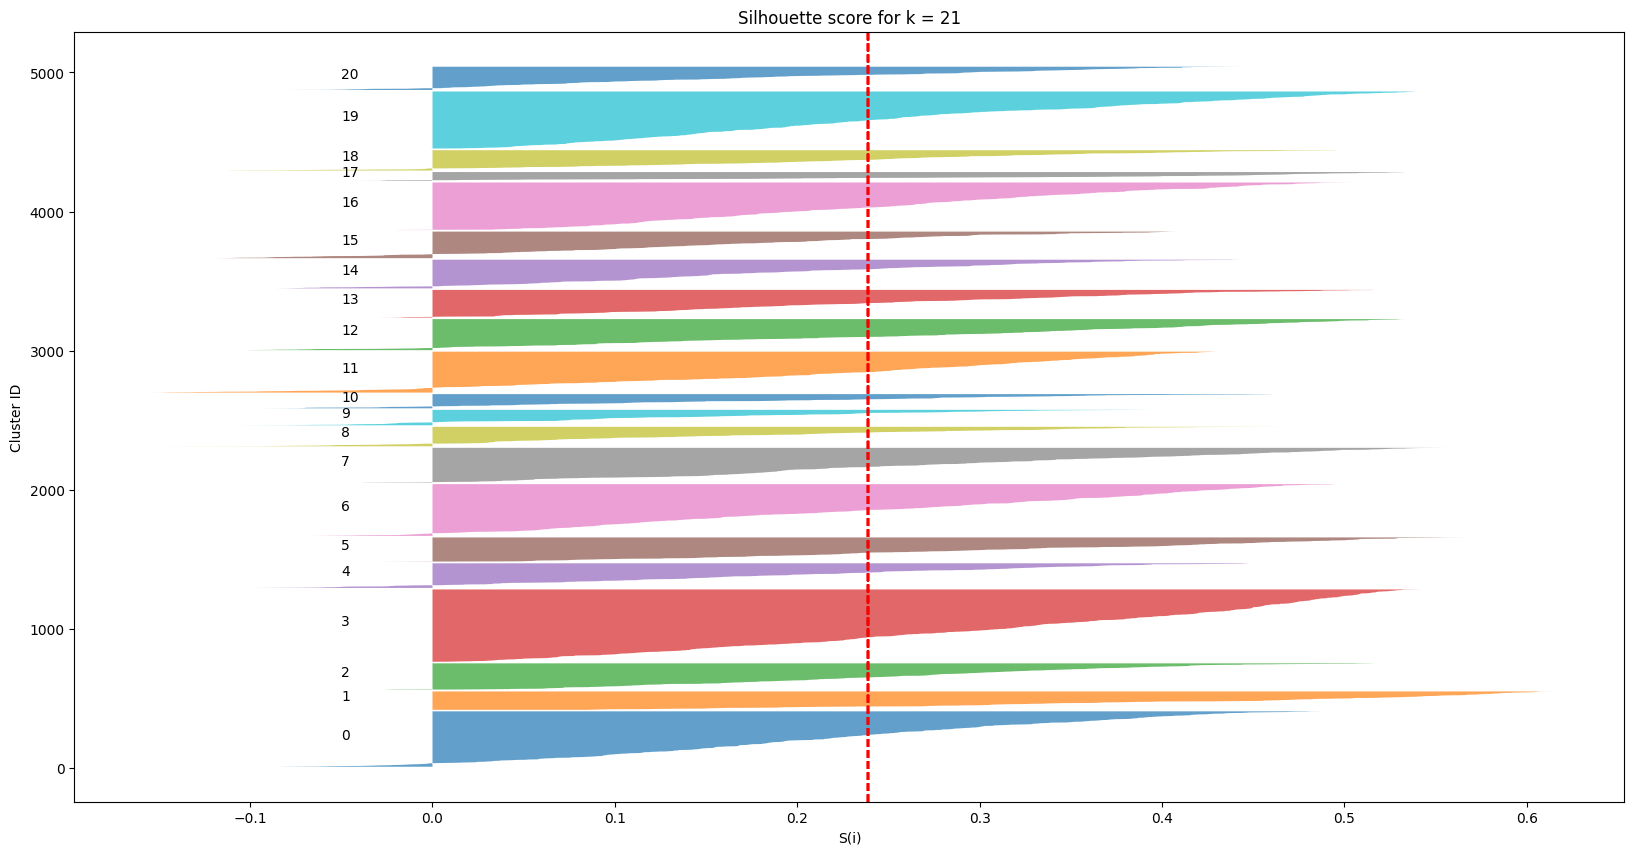

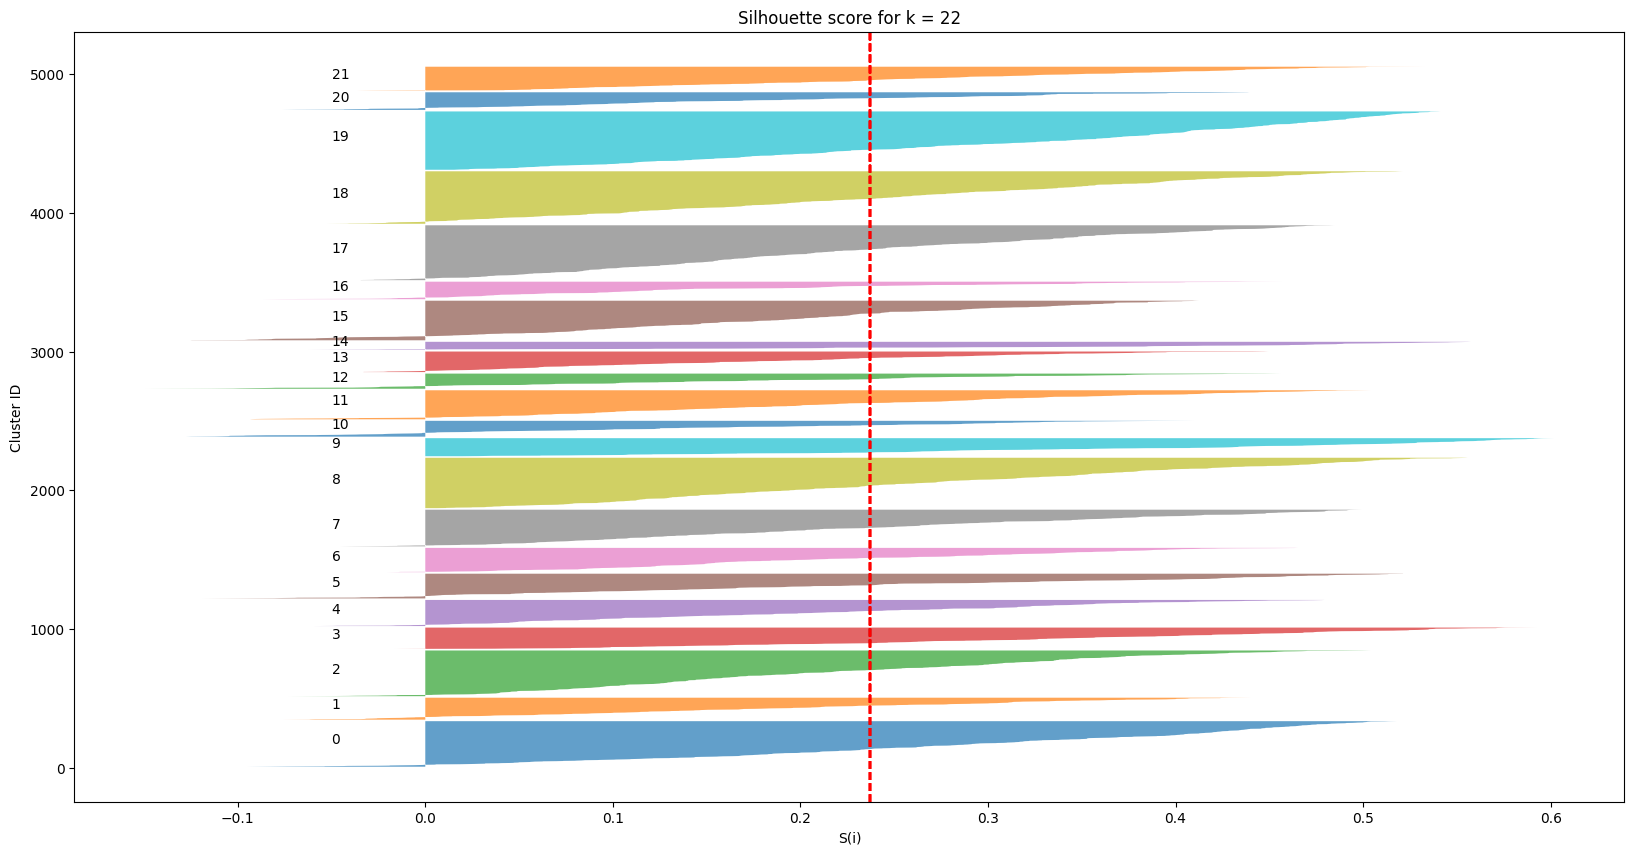

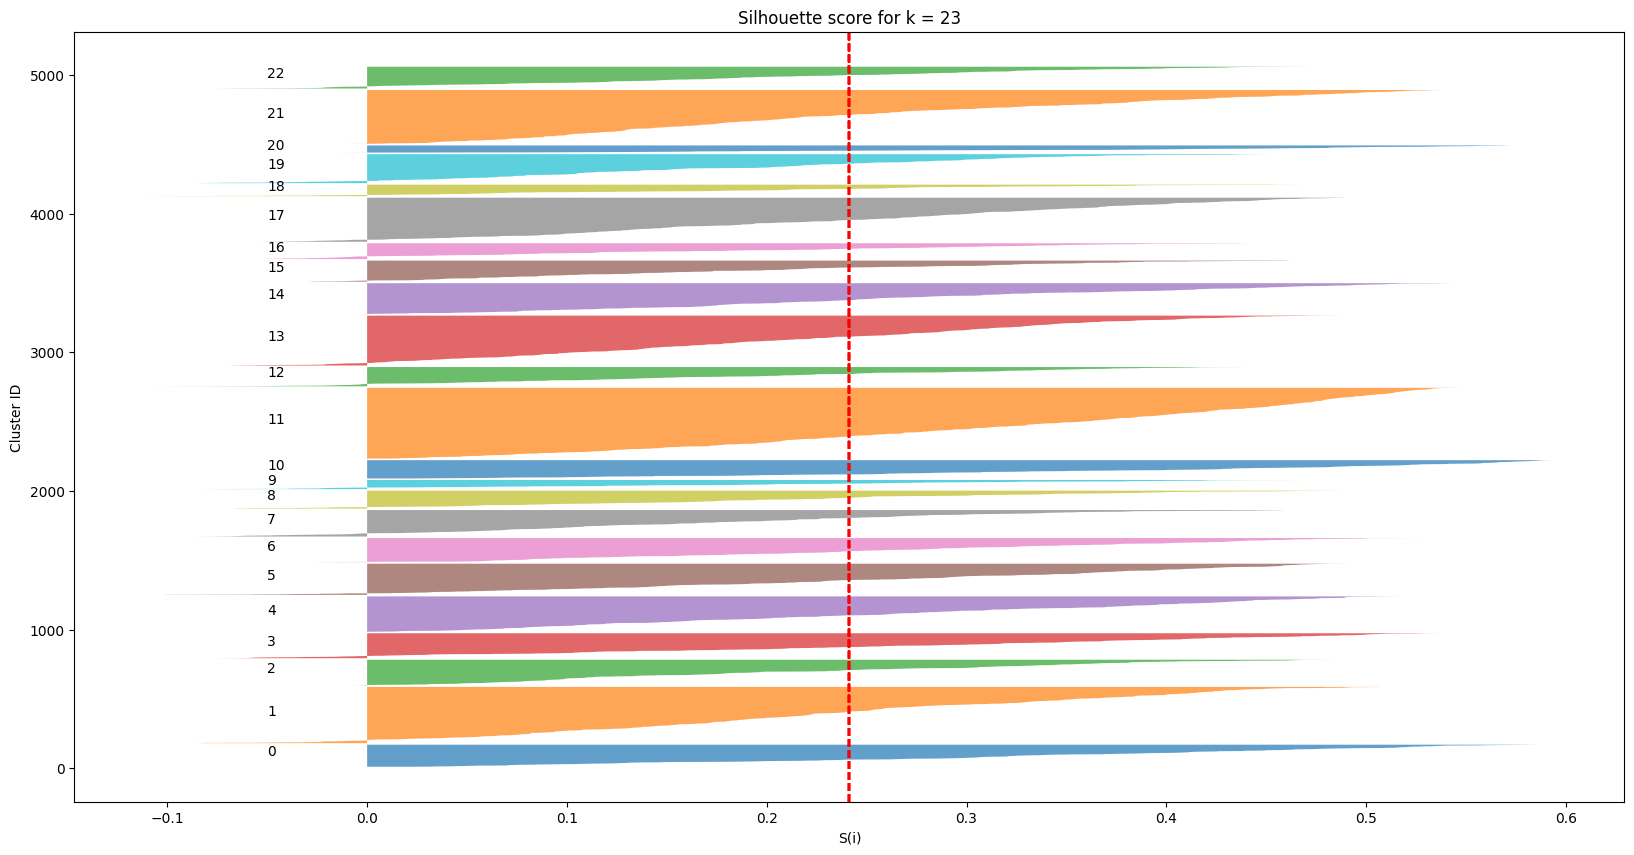

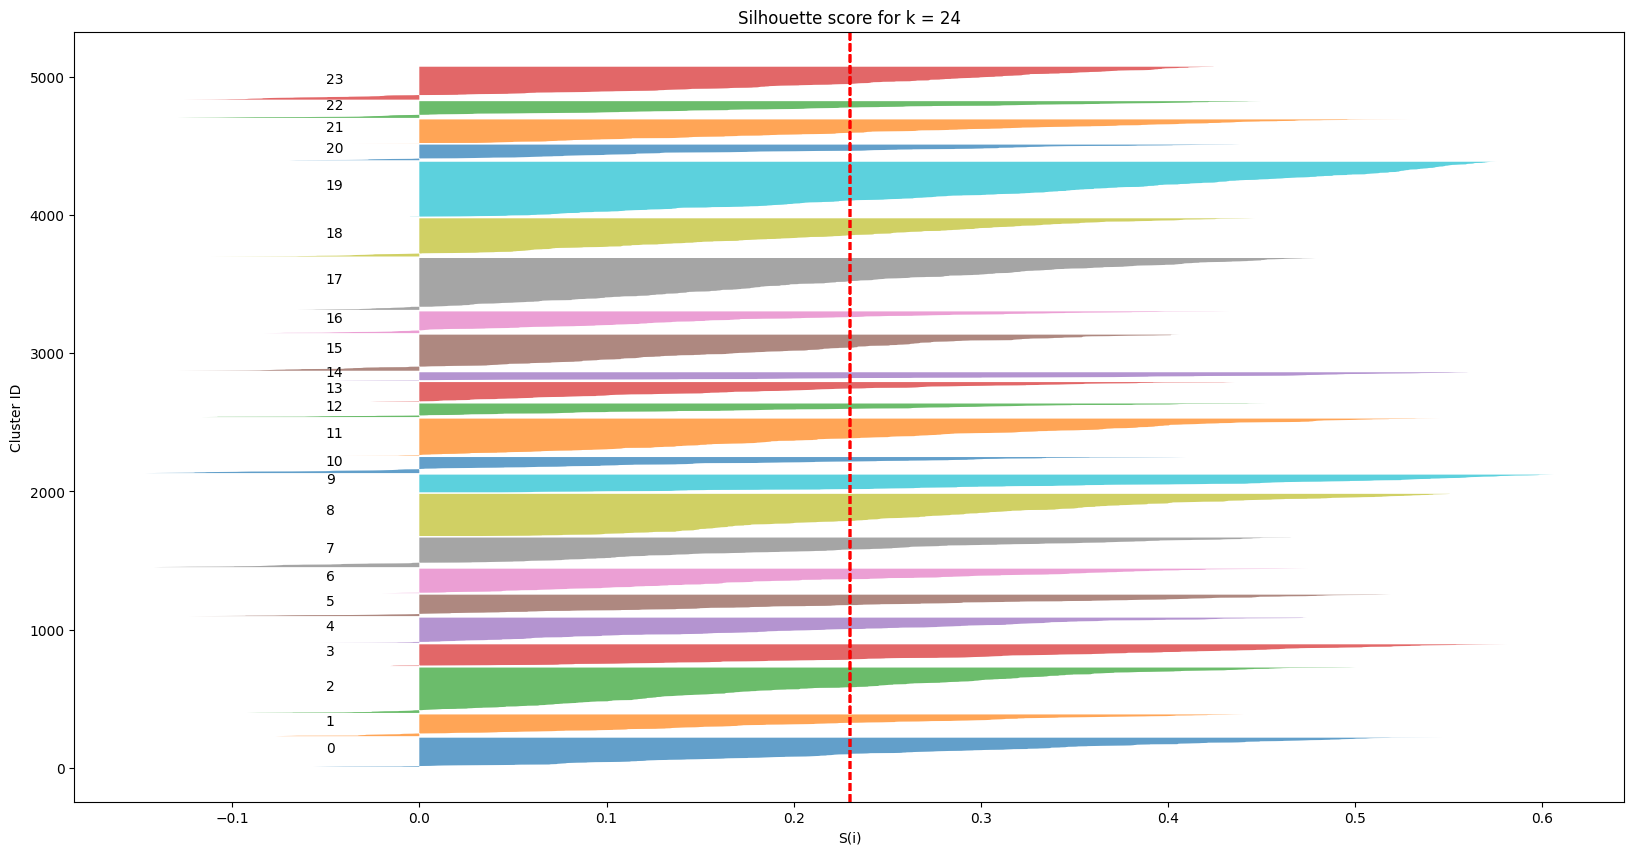

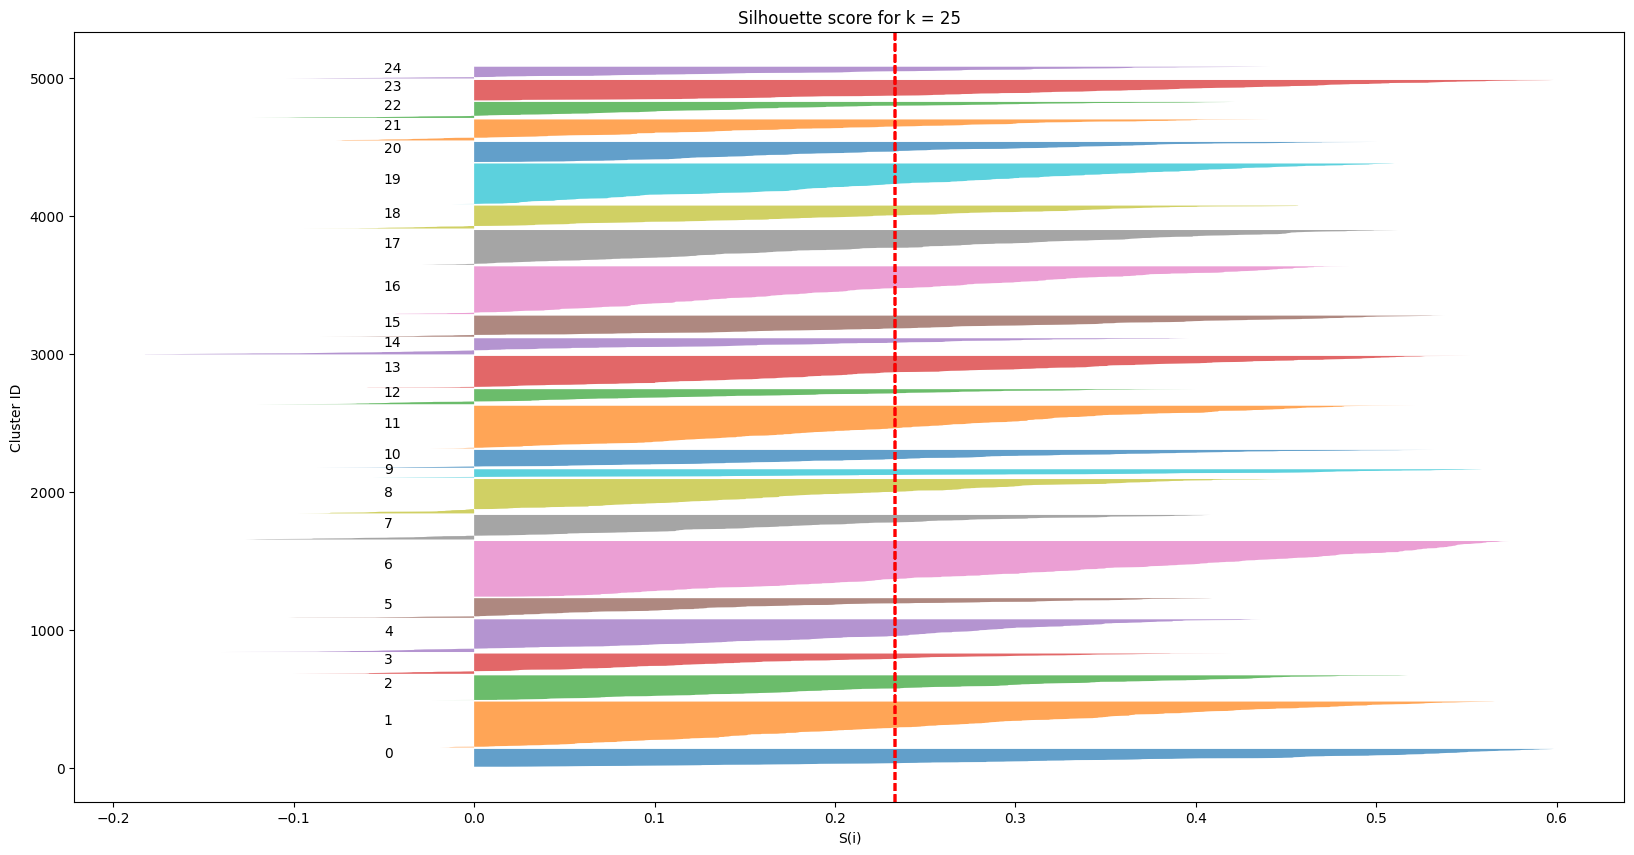

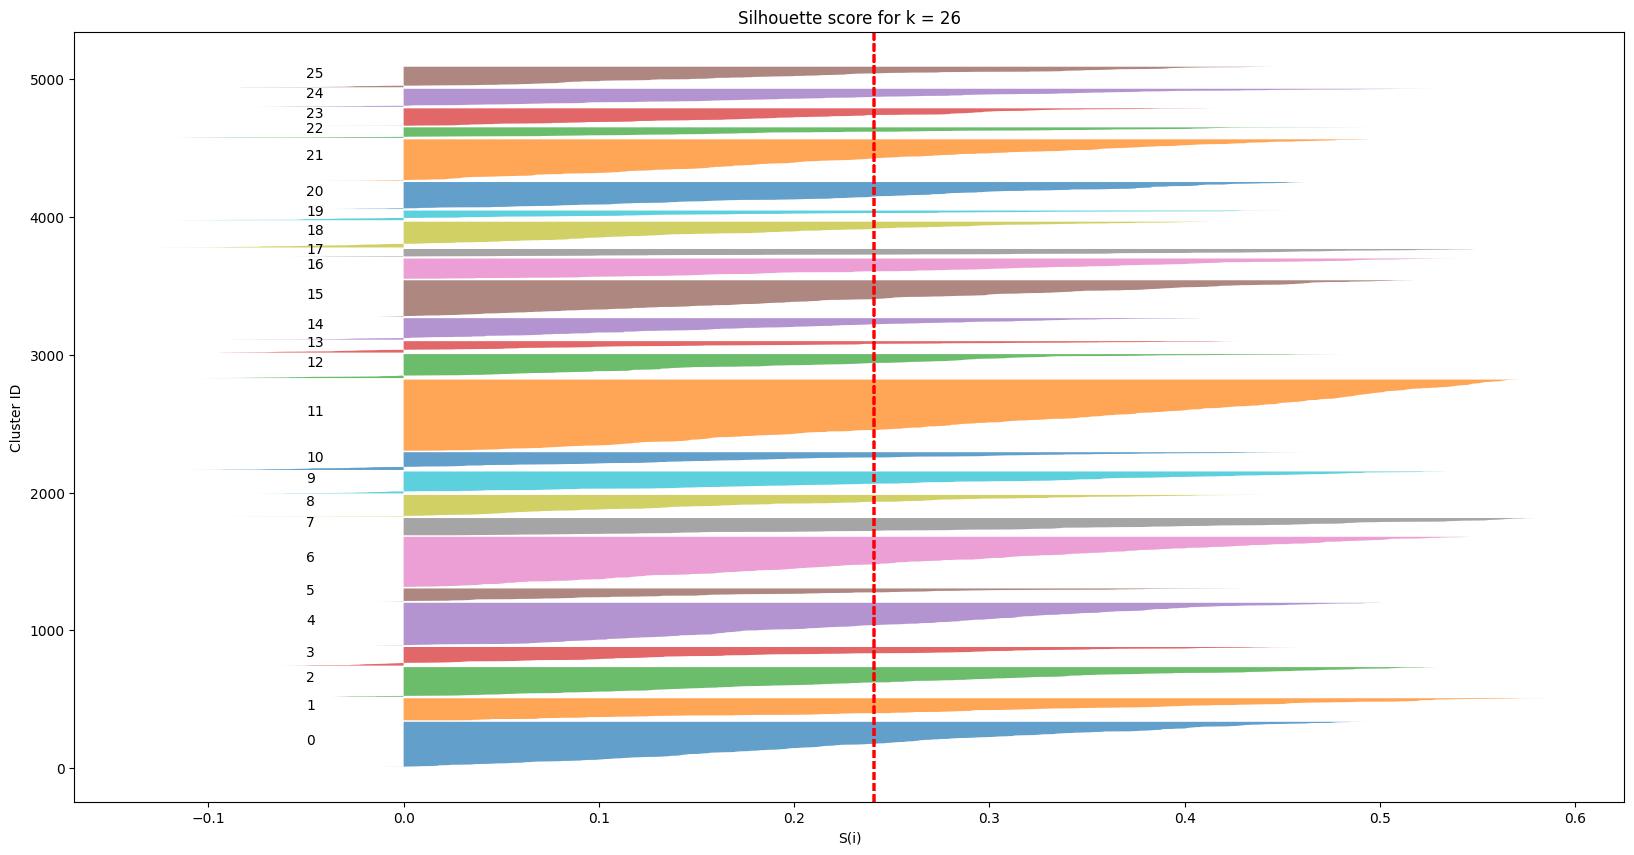

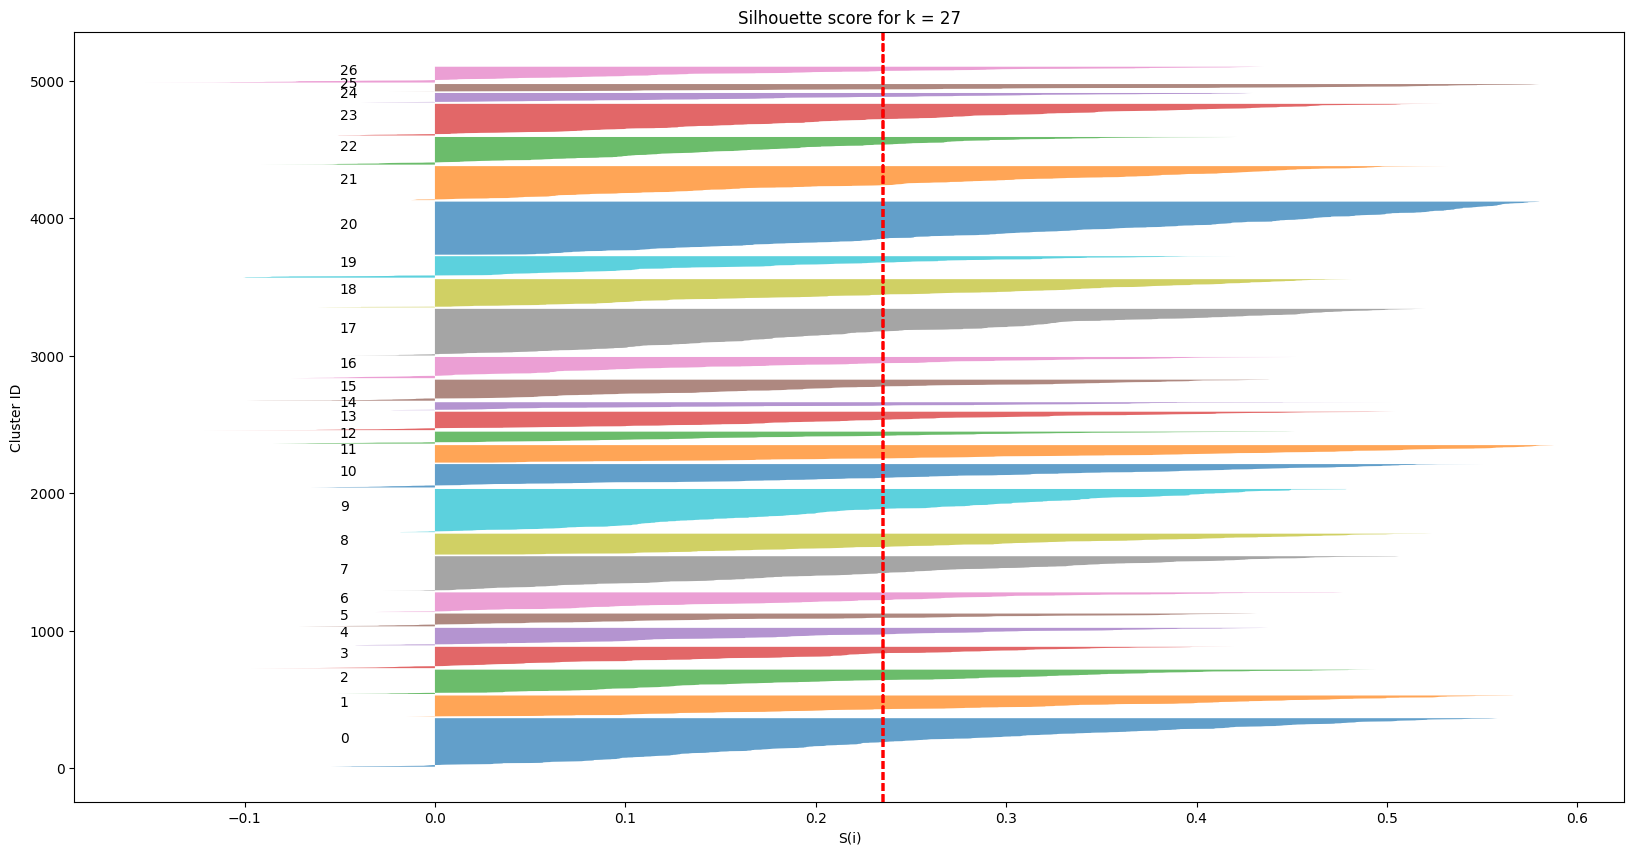

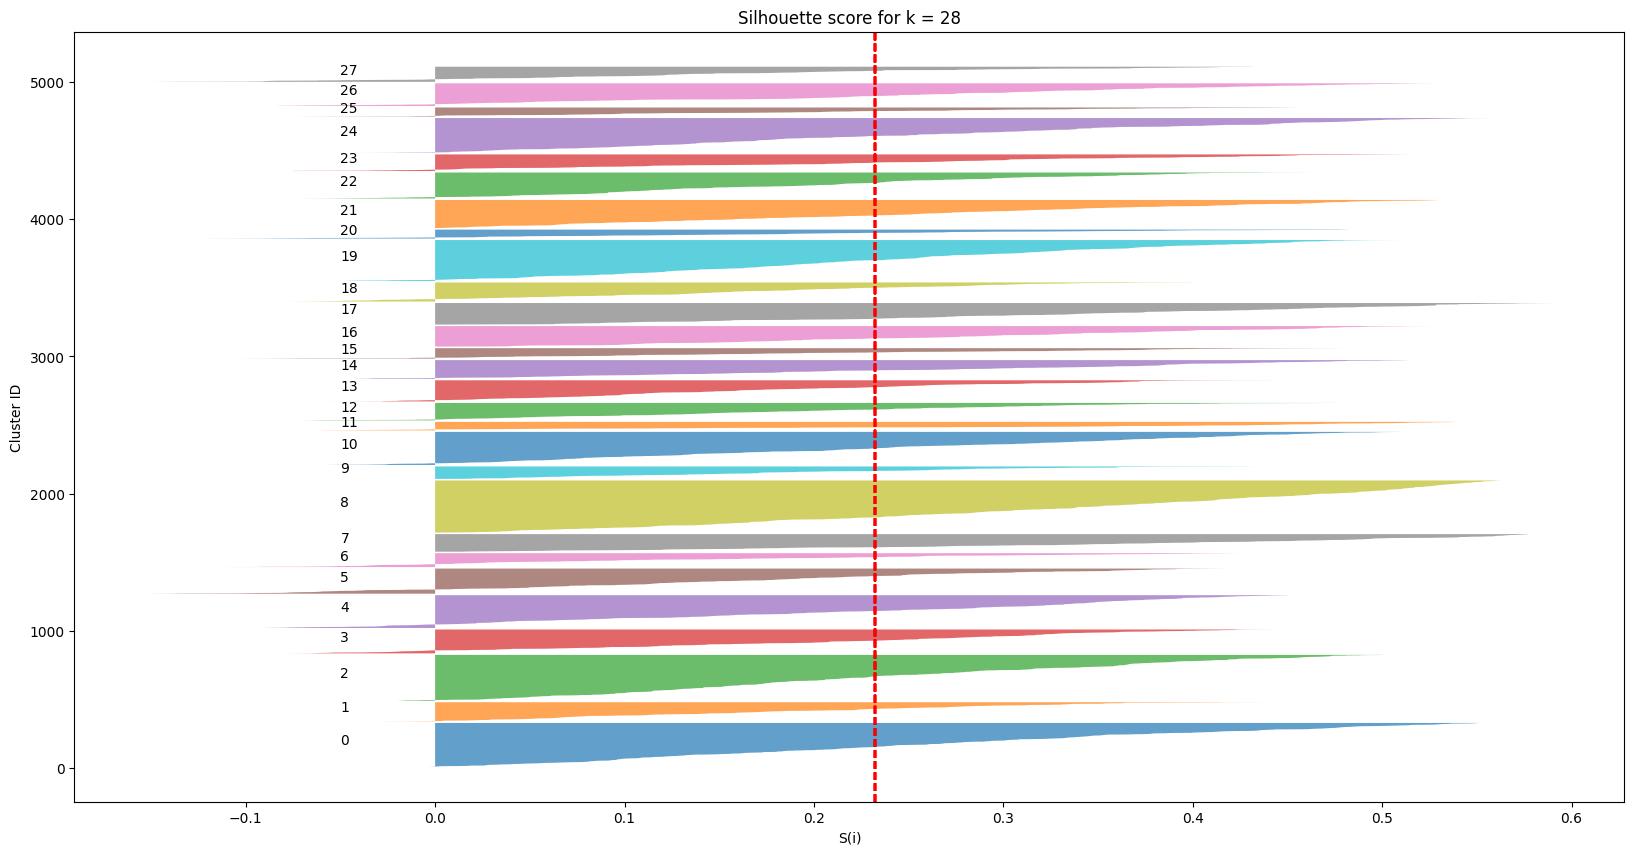

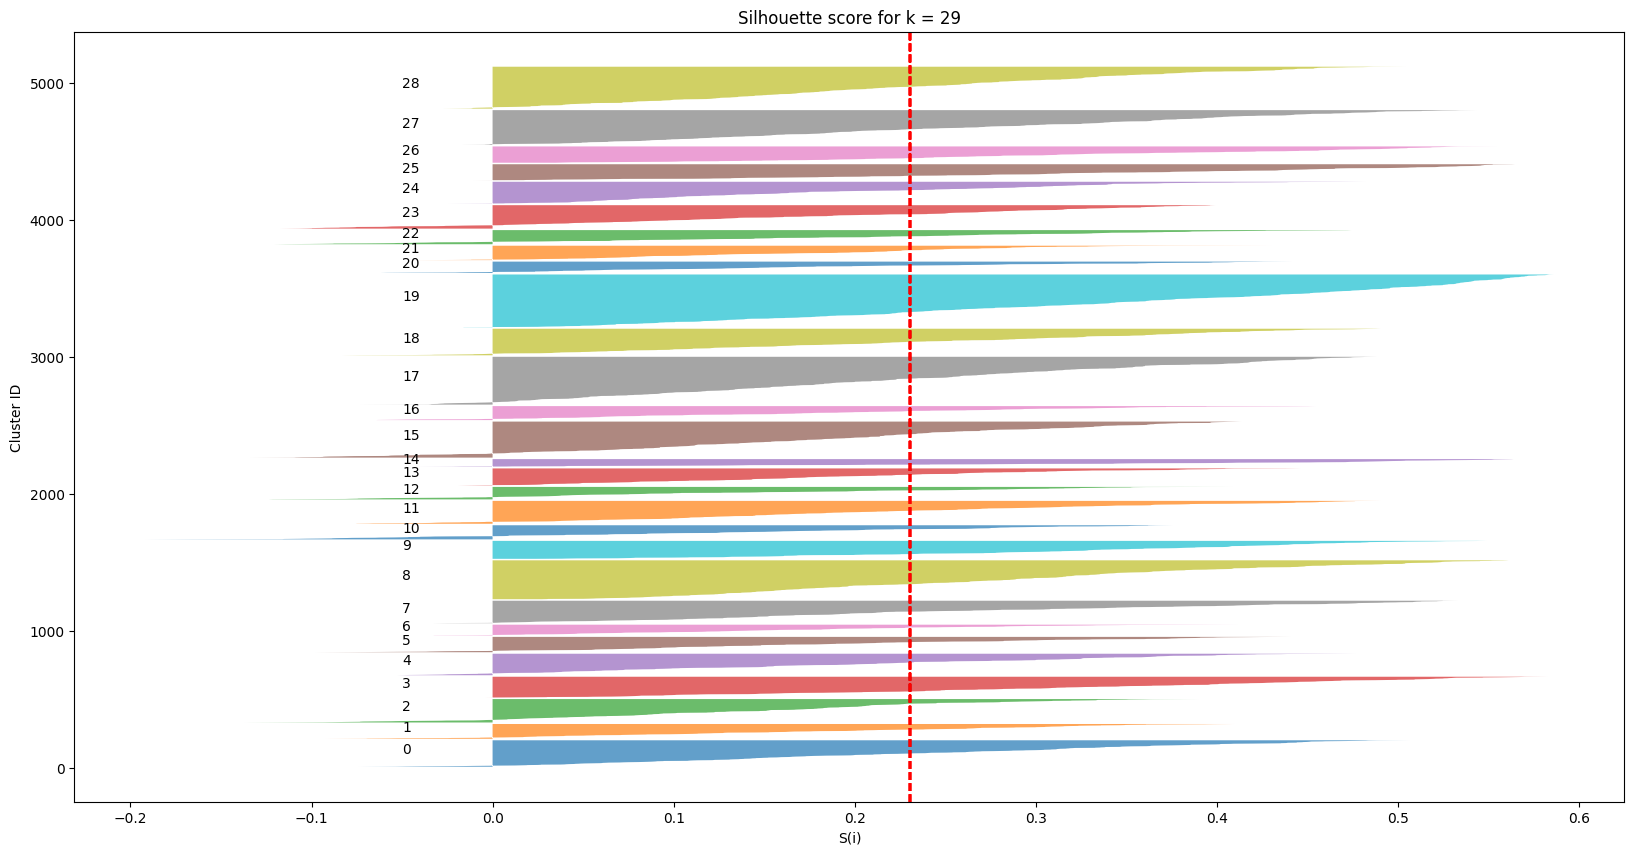

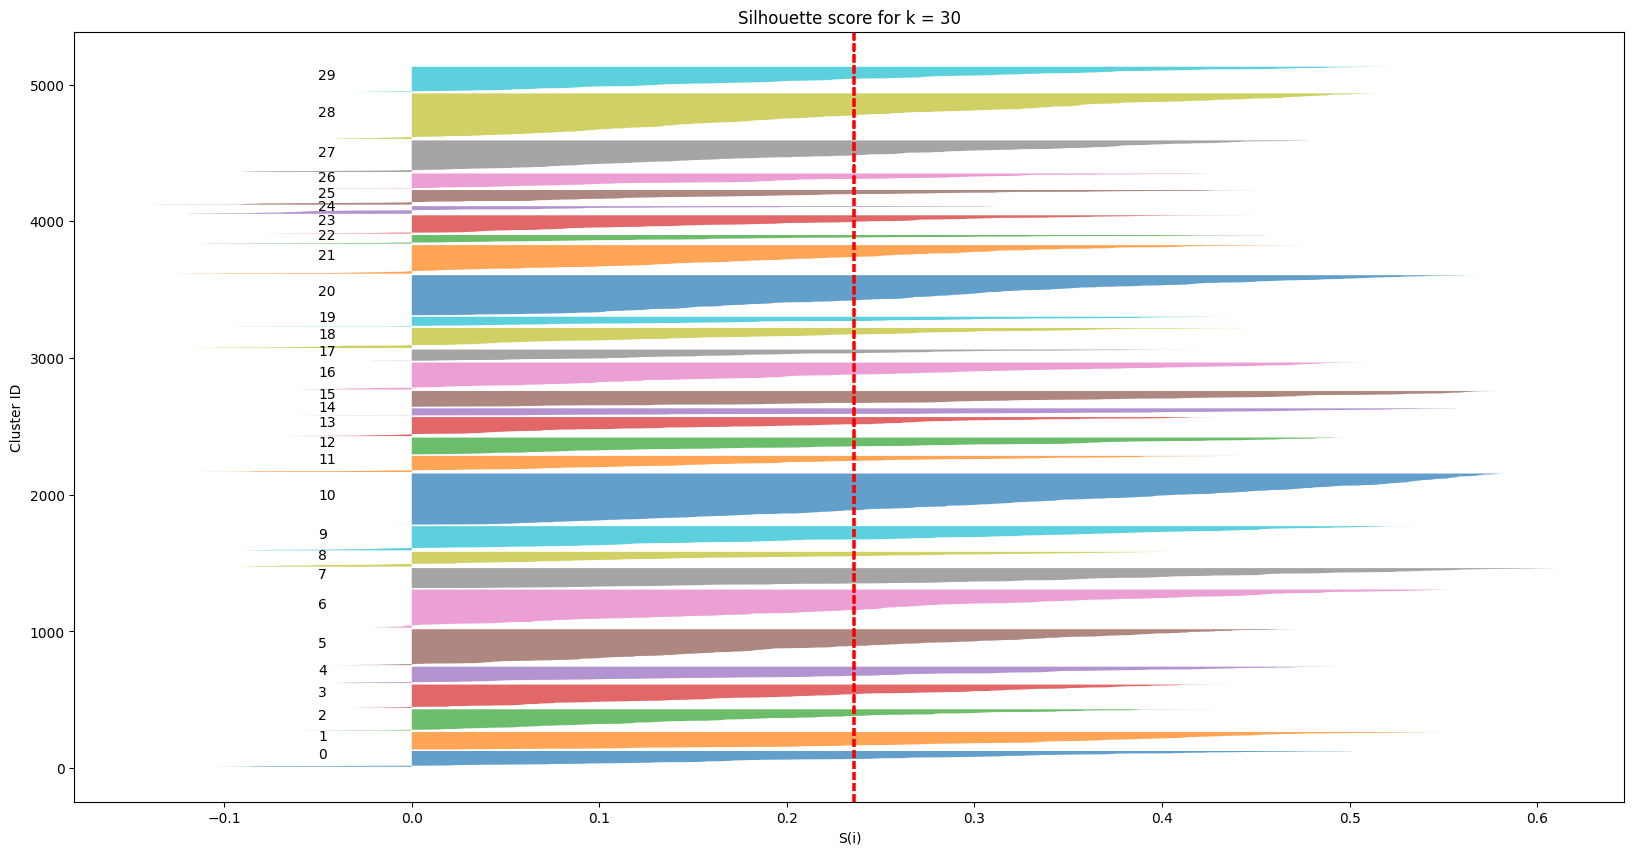

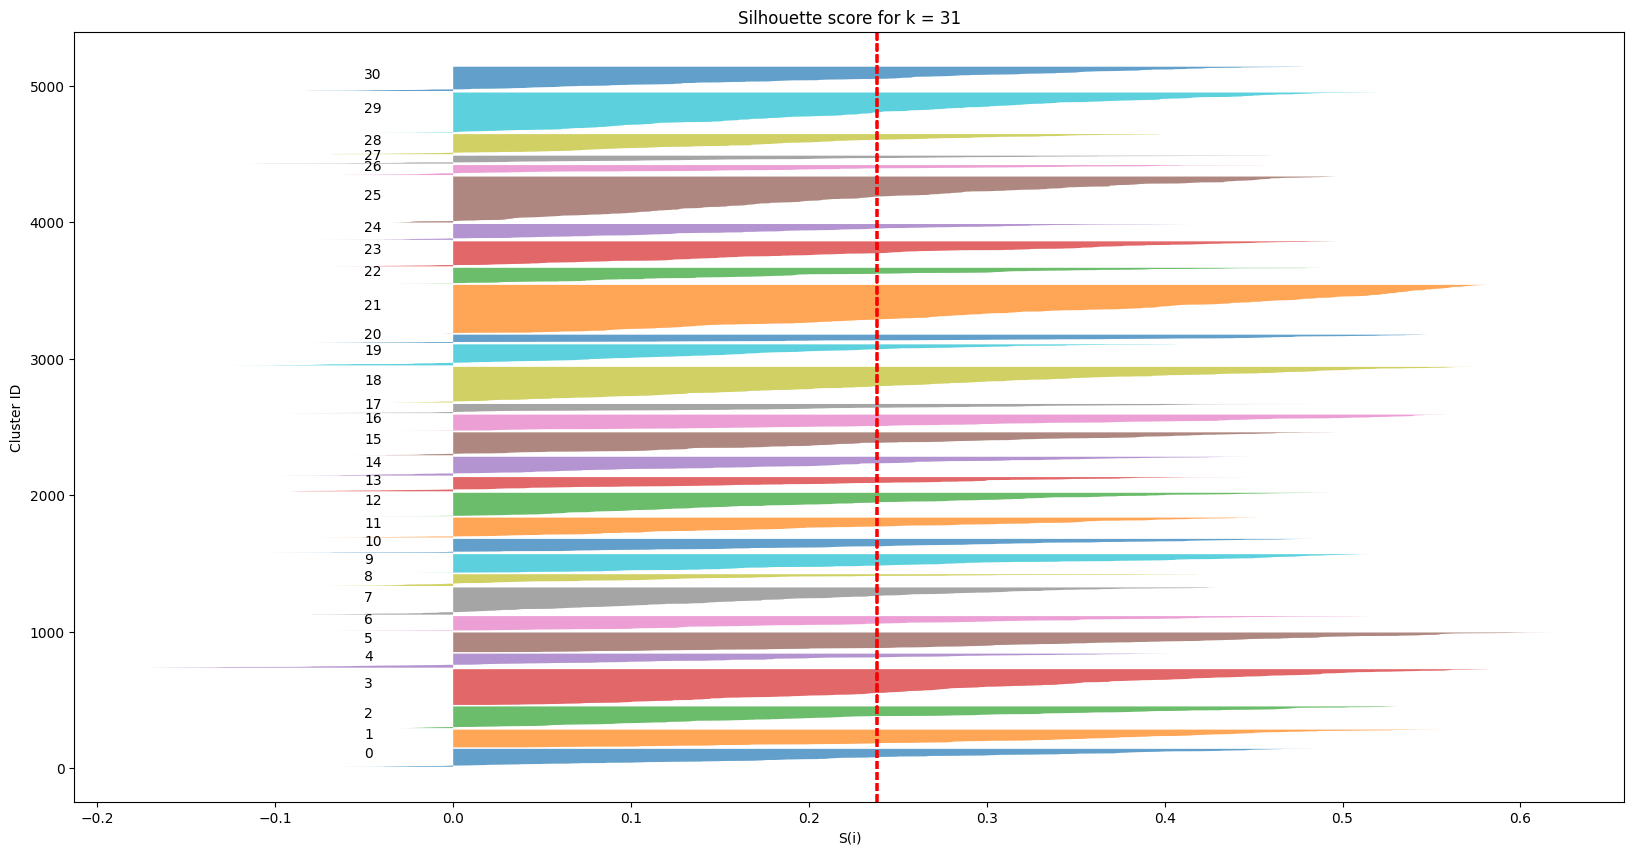

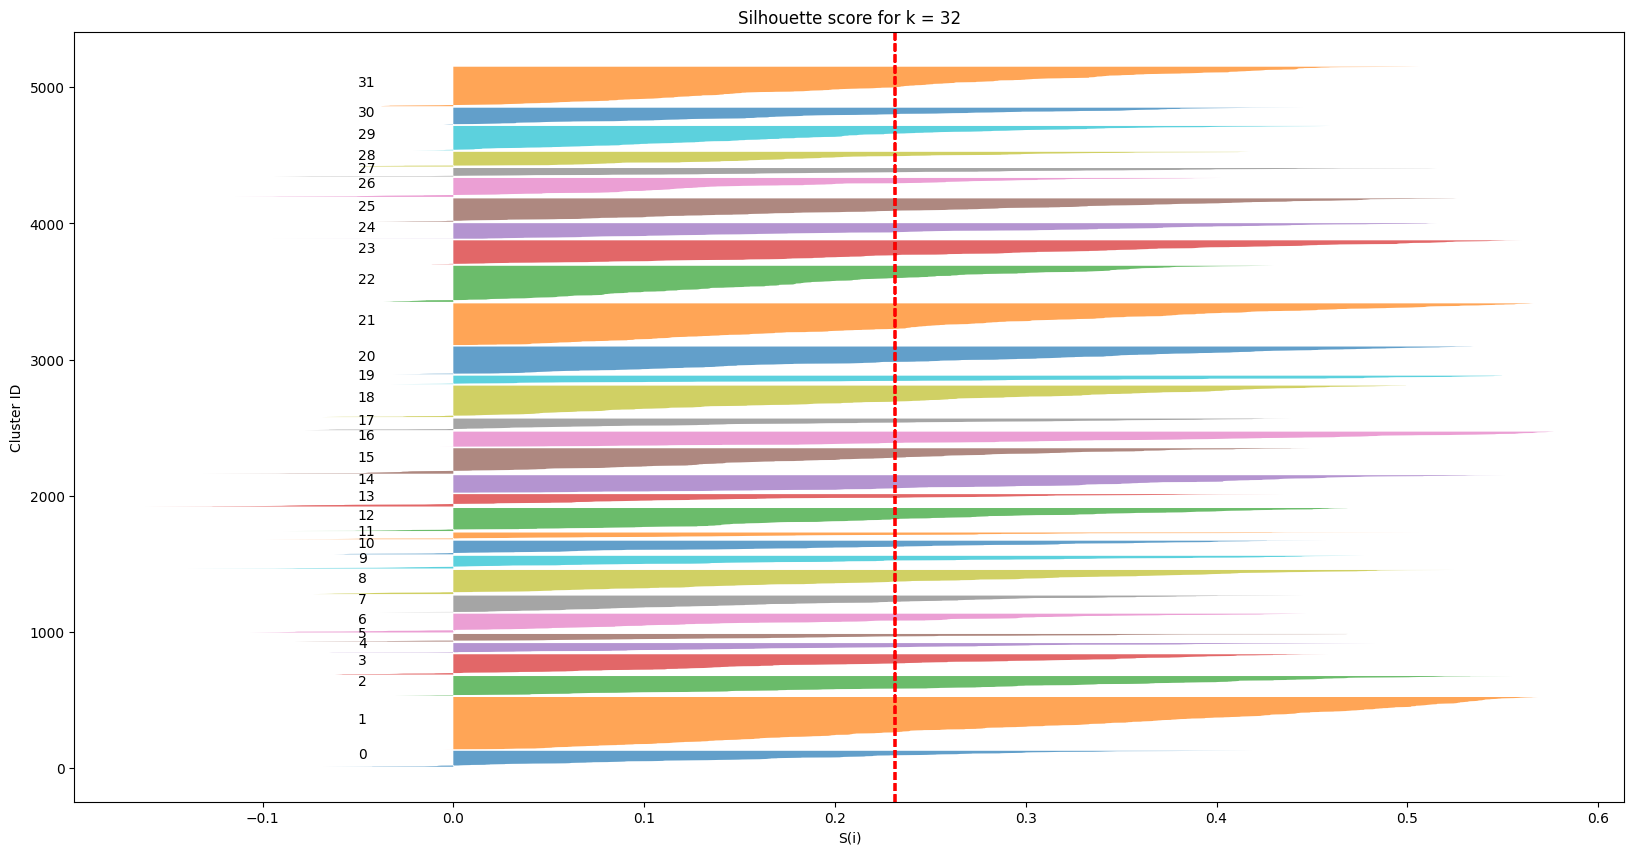

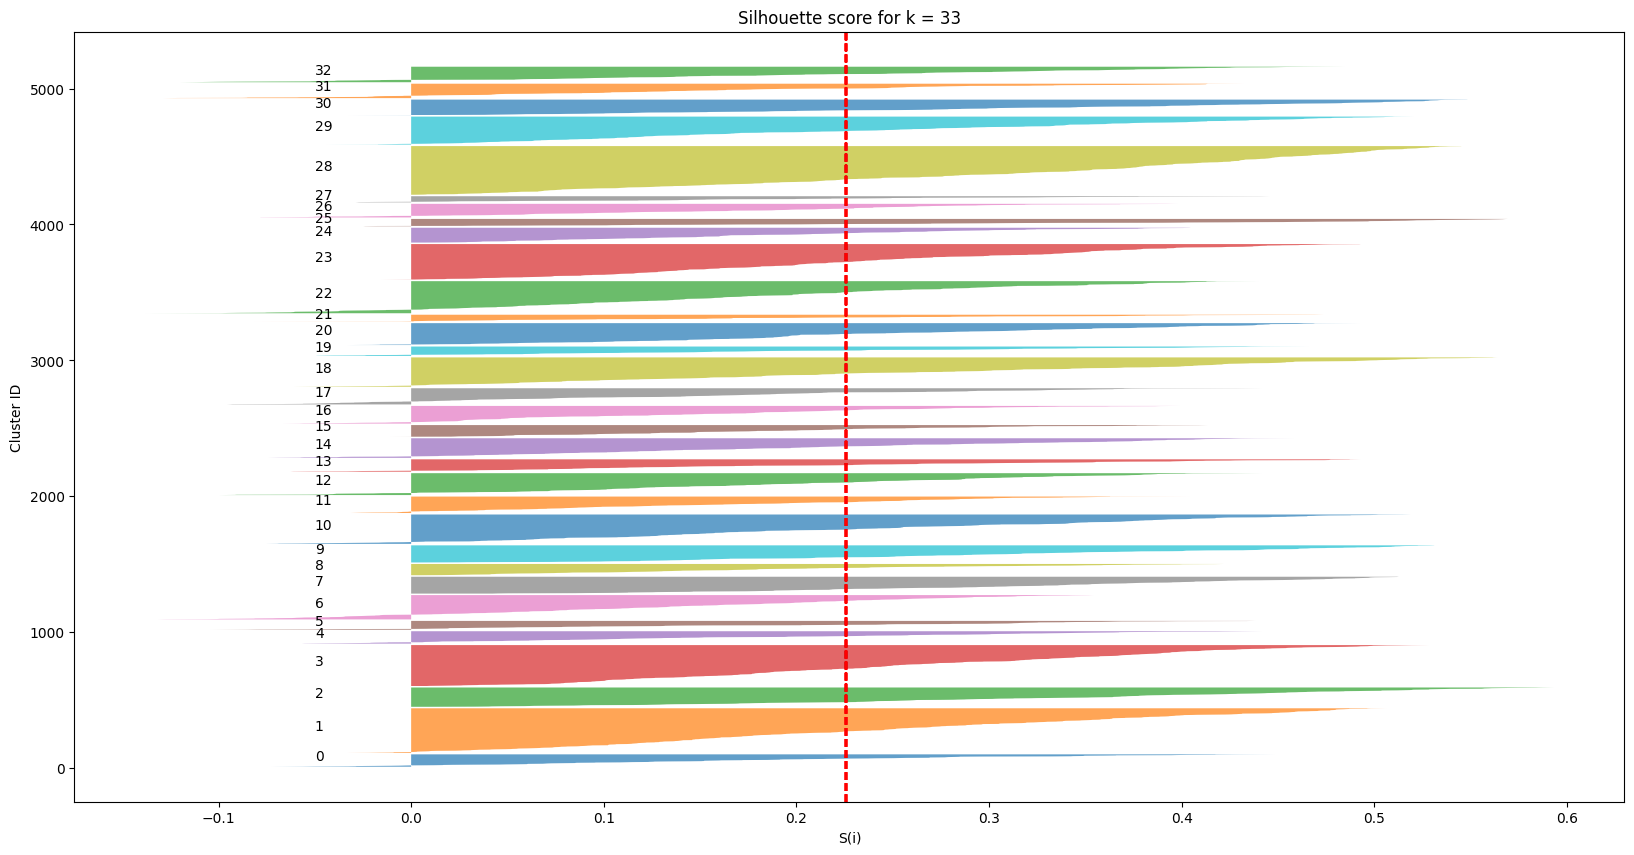

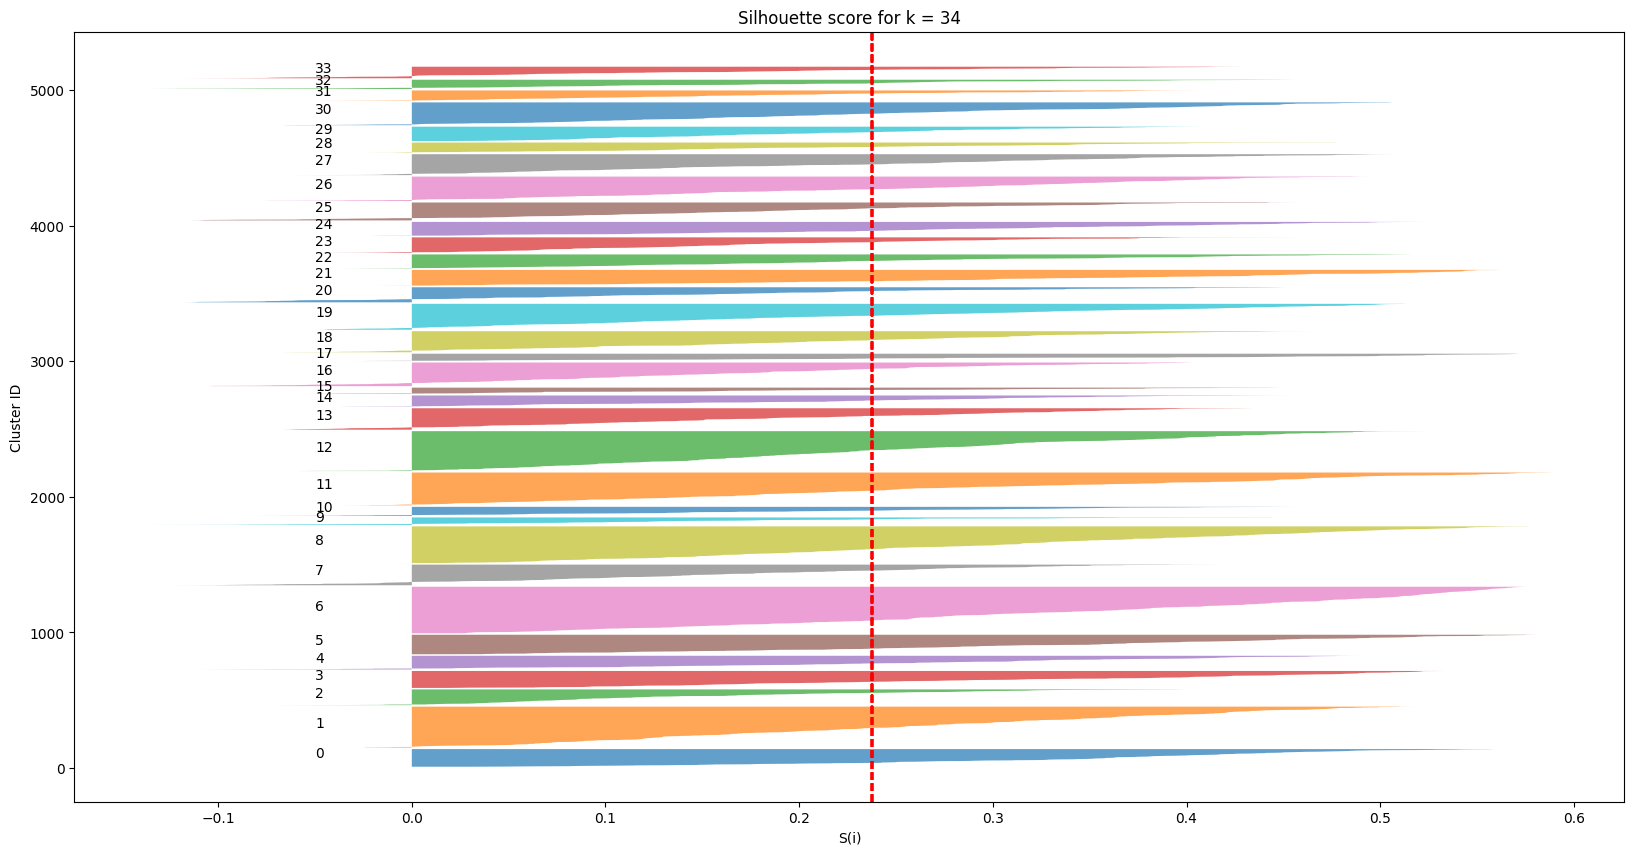

In [16]:
from sklearn import preprocessing,cluster
from sklearn.metrics import silhouette_score,silhouette_samples,pairwise_distances
import numpy as np

diff_k_inertia_l = []
diff_k_sil_score_l = []

for k_value in range(k_min,k_max):
    kmean_res = run_std_Kmean(songs_c_df,k_value)
    diff_k_inertia_l.append(round(kmean_res[0],5))
    diff_k_sil_score_l.append(round(kmean_res[1],5))
    #songs_df["clus_k_"+str(k_value)] = kmean_res[2]
    

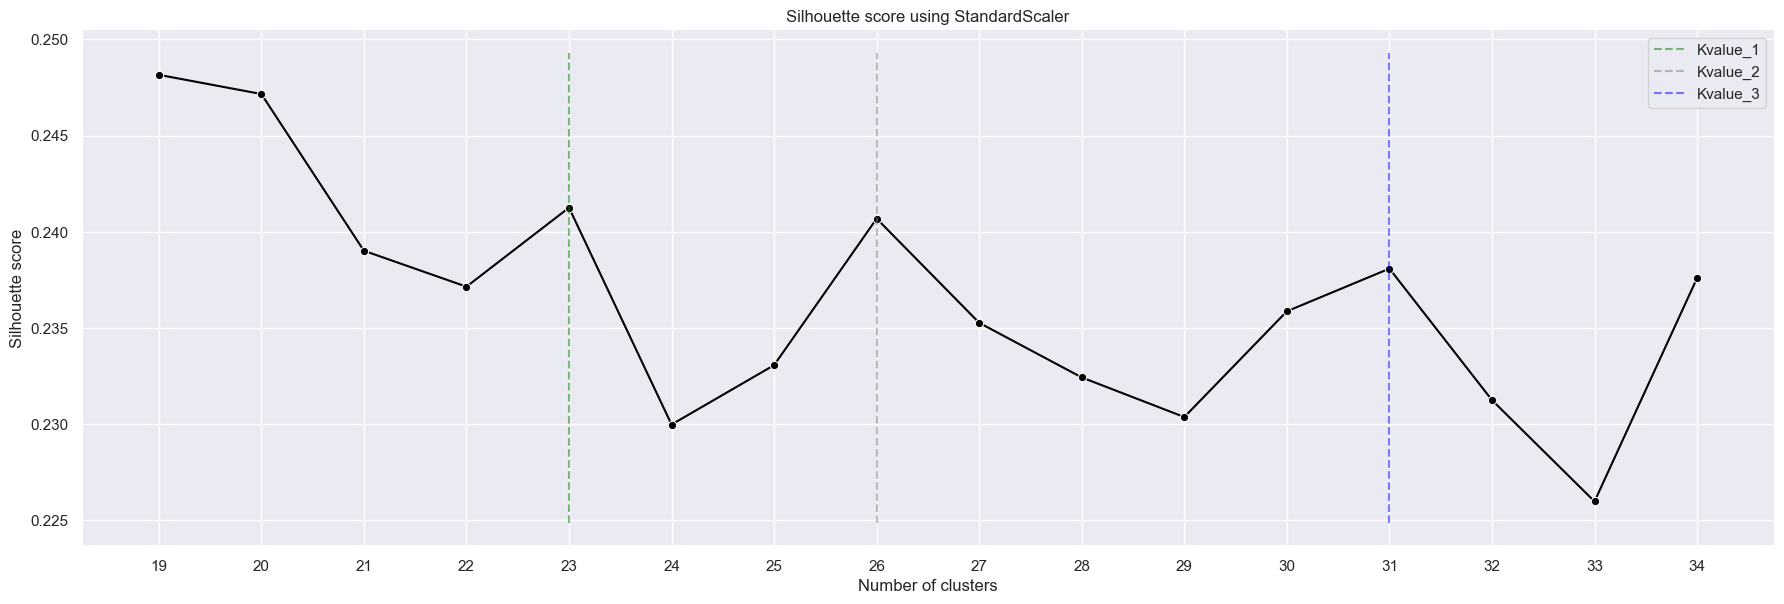

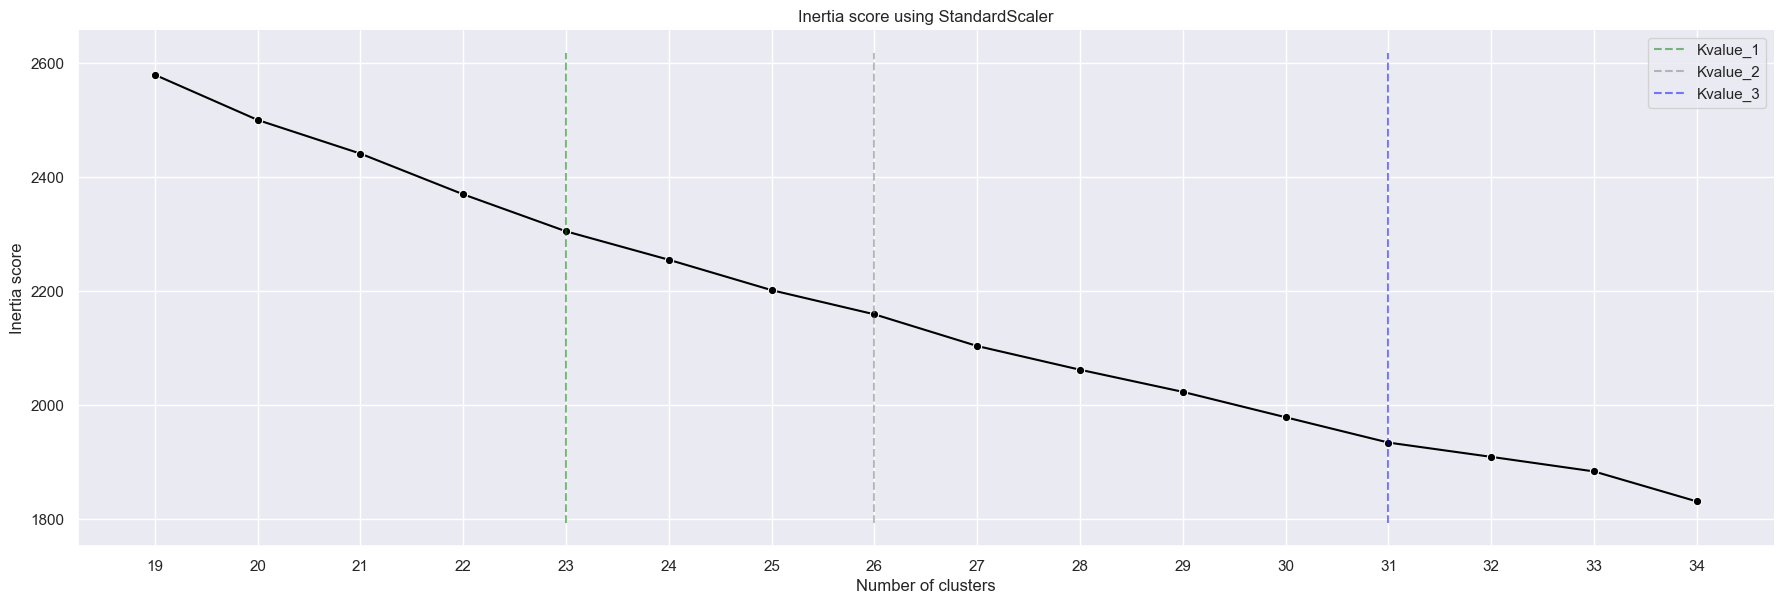

In [17]:


opt_k_vals = [23,26,31]
sns.set_theme(style='darkgrid', color_codes=True)

# Draw Silhouette score
plot = (
    sns.relplot(kind="line",x=range(k_min,k_max),y=diff_k_sil_score_l,marker='o',height=6,aspect=3,color="black")
    .set(title=f"Silhouette score using StandardScaler")
    .set_axis_labels("Number of clusters", "Silhouette score")
    .set(xticks=range(k_min,k_max,1))
)
ymin,ymax = plot.ax.get_ylim()
draw_3styled_vlines(opt_k_vals,ymin,ymax)


# Draw Inertia score
plot = (
    sns.relplot(kind="line",x=range(k_min,k_max),y=diff_k_inertia_l,marker='o',height=6,aspect=3,color="black")
    .set(title=f"Inertia score using StandardScaler")
    .set(xlabel="Number of clusters")
    .set(ylabel="Inertia score")
    .set(xticks=range(k_min,k_max,1))
)
ymin,ymax = plot.ax.get_ylim()
draw_3styled_vlines(opt_k_vals,ymin,ymax)

plt.show()

## Explore result of chosen K Value

* For k = 31 the average to silhouette is: 0.2381


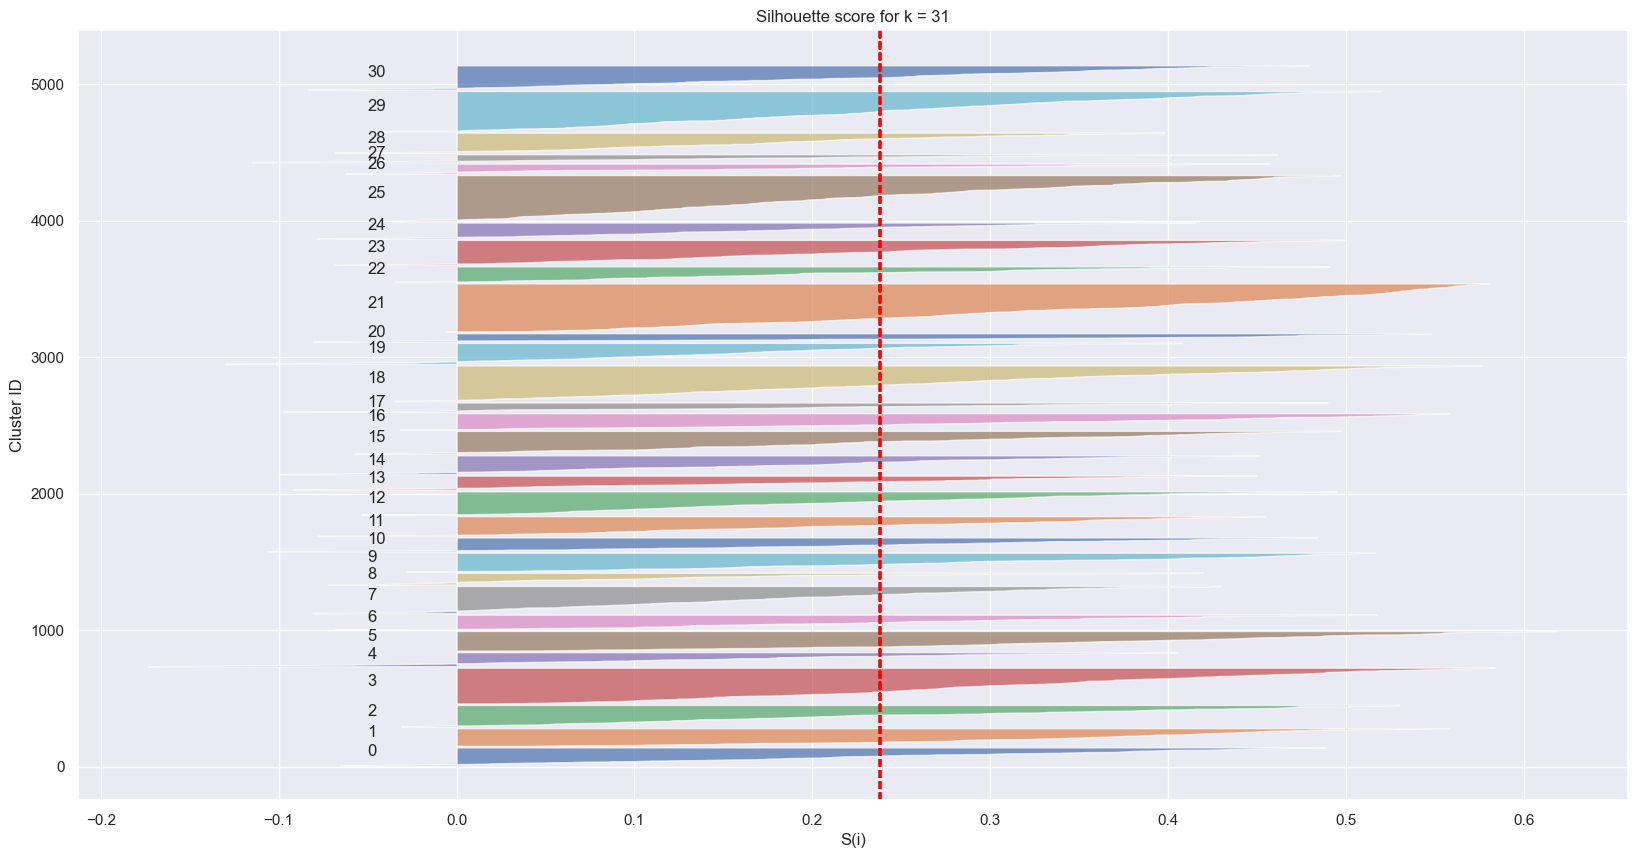

In [18]:

one_k =31

res = run_std_Kmean(songs_c_df,one_k)
songs_df["cluster"] = res[2]



In [19]:
songs_df

,name,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,duration_ms,time_signature,id,html,cluster
0,Se Eu Quiser Falar Com Deus ...,Gilberto Gil,0.658,0.2590,11,-13.141,0,0.0705,0.694,0.000059,0.9750,0.3060,110.376,,256213,4,1n7JnwviZ7zf0LR1tcGFq7,https://open.spotify.com/track/1n7JnwviZ7zf0LR...,22
1,Saudade De Bahia ...,Antônio Carlos Jobim,0.742,0.3990,2,-12.646,1,0.0346,0.217,0.000002,0.1070,0.6930,125.039,,191867,4,5QGM1U0eCYrQuwSJwTm5Zq,https://open.spotify.com/track/5QGM1U0eCYrQuwS...,28
2,"Canta Canta, Minha Gente ...",Martinho Da Vila,0.851,0.7300,2,-11.048,1,0.3470,0.453,0.000063,0.1240,0.9050,93.698,,152267,4,0NLIFSZxPzQhCwnkn5PJYs,https://open.spotify.com/track/0NLIFSZxPzQhCwn...,13
3,Mulher Eu Sei ...,Chico César,0.705,0.0502,4,-18.115,1,0.0471,0.879,0.000041,0.3860,0.5240,106.802,,186227,4,3mXqOdlLE1k67WsAxryPFs,https://open.spotify.com/track/3mXqOdlLE1k67Ws...,5
4,Rosa Morena ...,Kurt Elling,0.651,0.1190,6,-19.807,1,0.0380,0.916,0.000343,0.1040,0.4020,120.941,,273680,4,7bSzjzjTkWT2CkIPPdp0eA,https://open.spotify.com/track/7bSzjzjTkWT2CkI...,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5214,Sinfonia: III. In ruhig fliessender Bewegung ...,Luciano Berio,0.270,0.2560,7,-18.895,1,0.0680,0.860,0.151000,0.3740,0.1740,83.154,,707693,3,0lMDzAcO0RPdj30zcqUEU9,https://open.spotify.com/track/0lMDzAcO0RPdj30...,16
5219,"Elgar: Enigma Variations, Op. 36: XV. EDU (Fin...",Edward Elgar,0.146,0.2530,7,-18.408,1,0.0398,0.884,0.896000,0.0973,0.1360,80.359,,317240,4,2T1bhzjTfir3gsLRiudU1e,https://open.spotify.com/track/2T1bhzjTfir3gsL...,16
5223,"Also sprach Zarathustra, Op.30, TrV 176: Prelu...",Richard Strauss,0.115,0.3010,0,-13.321,1,0.0449,0.637,0.935000,0.1540,0.0409,77.276,,109667,4,3SOZcwfezNCWKs2vukSELD,https://open.spotify.com/track/3SOZcwfezNCWKs2...,24
5225,"Symphony No. 3 - ""Chant de la nuit"", Op. 27: L...",Karol Szymanowski,0.105,0.2310,7,-18.706,1,0.0516,0.673,0.053300,0.1570,0.0348,91.192,,589227,4,6VZ0CYMRhrdprO6u9rMwxC,https://open.spotify.com/track/6VZ0CYMRhrdprO6...,16


### check number of songs/cluster 

In [20]:
songs_per_clus =[]
for i in range (one_k):
    songs_per_clus.append((i,(songs_df.cluster == i).sum()))

In [21]:
songs_per_clus

[(0, 132),
 (1, 131),
 (2, 160),
 (3, 263),
 (4, 104),
 (5, 145),
 (6, 110),
 (7, 200),
 (8, 87),
 (9, 137),
 (10, 102),
 (11, 146),
 (12, 172),
 (13, 105),
 (14, 139),
 (15, 169),
 (16, 120),
 (17, 68),
 (18, 262),
 (19, 155),
 (20, 61),
 (21, 355),
 (22, 115),
 (23, 184),
 (24, 117),
 (25, 338),
 (26, 74),
 (27, 59),
 (28, 148),
 (29, 295),
 (30, 179)]

In [28]:
songs_df.loc[songs_df.cluster == 27].drop(["danceability","key","loudness","mode","speechiness","instrumentalness","liveness","valence","duration_ms","time_signature"],axis=1).html

8       https://open.spotify.com/track/1wL2dk42Cxu4zCJs4SvFsZ
37      https://open.spotify.com/track/4lnLWhIiUKxq4Rh898vkVk
117     https://open.spotify.com/track/2moGHNaU8a4j1iowyOiYnF
129     https://open.spotify.com/track/5cEHUIuDkbTtFW5eoTp4bI
192     https://open.spotify.com/track/3tpkutDbpsa2P09FNNlnmt
258     https://open.spotify.com/track/6TlLq2hP4KtTLiEp8MYmS4
405     https://open.spotify.com/track/2oezpnnea1VXHpJEbqnBhw
851     https://open.spotify.com/track/2JoXjemDQe0fSmk26CpfrP
857     https://open.spotify.com/track/7ItZM6DMZE2m1X7yIaRxjq
861     https://open.spotify.com/track/4gphxUgq0JSFv2BCLhNDiE
862     https://open.spotify.com/track/5hznMxKe11iqwcW8BFlNWZ
880     https://open.spotify.com/track/4tmy6FB76bR5eLmx0zO1mn
892     https://open.spotify.com/track/1s4hyUFWmLWiAamsclb4xA
934     https://open.spotify.com/track/3yrSvpt2l1xhsV9Em88Pul
944     https://open.spotify.com/track/3SMQvRU807fzOwZGagys3n
984     https://open.spotify.com/track/6V9VCm1zOY2lGR80RehJ9i
1017    

In [26]:
pd.set_option('display.max_colwidth', 80)

### Find nearest n points to each centroid

In [29]:
from sklearn import preprocessing,cluster
from sklearn.metrics import silhouette_score,silhouette_samples,pairwise_distances,pairwise_distances_argmin_min
import numpy as np
import pandas as pd

my_scaler = preprocessing.StandardScaler().set_output(transform='pandas')
scaled_df_2 = my_scaler.fit_transform(songs_c_df)
    
# Operate KMean Method
my_model = cluster.KMeans(n_clusters=5,n_init=10, random_state=123)
my_model.fit(scaled_df_2)

cluster_centers_df = pd.DataFrame(data=my_model.cluster_centers_, columns= scaled_df_2.columns)
scaled_df_2['cluster'] = my_model.labels_
#scaled_df_2["centroid"]
cluster_centers_df
list_of_playlists= []
# for i in range(12):
#     list_of_playlists.append(scaled_df_2.query('cluster == @i'))
#     list_of_playlists[i] = list_of_playlists[i].assign(distance=0)
#     for j, song in list_of_playlists[i].iterrows():
#         total = sum(((song.iloc[pos]- cluster_centers_df.iloc[1][pos])**2) for pos in range(scaled_df_2.shape[1]-3))**(1/2)
#         list_of_playlists[i].loc[j,'distance'] = total
#     list_of_playlists[i] = list_of_playlists[i].sort_values('distance').head(50)
#     list_of_playlists[i] = list_of_playlists[i].reset_index()

KeyError: 'centroid'

In [25]:
list_of_playlists[0]


,index,energy,acousticness,tempo,loudness,cluster,distance
0,4262,0.274441,-0.756938,0.556065,-1.834295,0,0.324886
1,4125,0.198104,-0.758637,0.491702,-1.812414,0,0.372184
2,1276,0.009270,-0.547553,0.361214,-1.238825,0,0.441823
3,3676,0.065519,-0.758498,-0.144198,-1.571472,0,0.470929
4,4336,0.041412,-0.756252,0.291000,-1.164084,0,0.489348
5,4155,0.037395,-0.758536,0.585658,-1.896497,0,0.493955
6,4124,0.037395,-0.758689,0.213510,-2.135472,0,0.494041
7,889,0.017306,-0.207202,-0.509258,-1.085409,0,0.508768
8,4126,0.017306,-0.758267,0.421714,-1.897235,0,0.510554
9,4324,0.234263,-0.003493,-0.356866,-1.156216,0,0.522448
